# Usage 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pertpy
from deres import DEResult
import scanpy as sc
import numpy as np
import pandas as pd

/home/sturm/projects/scverse/deres/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Build example dataset

For the sake of this example, we just go with the `pbmc3k` dataset and assign a random sample identifier to
each cell to mimick a multi-sample dataset. 

In [3]:
adata = sc.datasets.pbmc3k_processed()
adata.obs["sample"] = pd.Categorical([f"sample_{x}" for x in np.random.randint(0, 10, adata.shape[0])])
# raw.X contains log-normalized values which we are going to use here
adata = sc.AnnData(adata.raw.X, obs=adata.obs, var=adata.raw.var)

## Run differential expression testing

We first contruct a pseudobulk-object and then use the statsmodels implementation in pertpy to 
compare gene expression between cell-types. For the sake of the example, we
compare CD8+ T cells with CD4+ T cells and NK cells. 

In [4]:
pb = sc.get.aggregate(adata, ["sample", "louvain"], "mean")

In [5]:
mod = pertpy.tl.Statsmodels(pb, design="~ louvain", layer="mean")
mod.fit()

  0%|                                                                                                                                                                                                                           | 0/13714 [00:00<?, ?it/s]

  1%|█▋                                                                                                                                                                                                             | 108/13714 [00:00<00:12, 1074.88it/s]

  2%|███▎                                                                                                                                                                                                           | 219/13714 [00:00<00:12, 1093.69it/s]

  2%|████▉                                                                                                                                                                                                          | 329/13714 [00:00<00:12, 1093.64it/s]

  3%|██████▉                                                                                                                                                                                                        | 456/13714 [00:00<00:11, 1161.32it/s]

  4%|████████▋                                                                                                                                                                                                      | 573/13714 [00:00<00:11, 1139.25it/s]

  5%|██████████▍                                                                                                                                                                                                    | 688/13714 [00:00<00:11, 1127.14it/s]

  6%|████████████                                                                                                                                                                                                   | 801/13714 [00:00<00:11, 1120.79it/s]

  7%|█████████████▊                                                                                                                                                                                                 | 914/13714 [00:00<00:11, 1122.26it/s]

  7%|███████████████▍                                                                                                                                                                                              | 1027/13714 [00:00<00:11, 1118.72it/s]

  8%|█████████████████▏                                                                                                                                                                                            | 1148/13714 [00:01<00:10, 1144.35it/s]

  9%|███████████████████▏                                                                                                                                                                                          | 1280/13714 [00:01<00:10, 1197.27it/s]

 10%|█████████████████████▏                                                                                                                                                                                        | 1413/13714 [00:01<00:09, 1236.10it/s]

 11%|███████████████████████▏                                                                                                                                                                                      | 1546/13714 [00:01<00:09, 1263.27it/s]

 12%|█████████████████████████▏                                                                                                                                                                                    | 1678/13714 [00:01<00:09, 1277.65it/s]

 13%|███████████████████████████▏                                                                                                                                                                                  | 1807/13714 [00:01<00:09, 1279.53it/s]

 14%|█████████████████████████████                                                                                                                                                                                 | 1935/13714 [00:01<00:09, 1210.54it/s]

 15%|██████████████████████████████▉                                                                                                                                                                               | 2057/13714 [00:01<00:09, 1170.20it/s]

 16%|████████████████████████████████▋                                                                                                                                                                             | 2175/13714 [00:01<00:10, 1141.37it/s]

 17%|██████████████████████████████████▌                                                                                                                                                                           | 2297/13714 [00:01<00:09, 1161.46it/s]

 18%|████████████████████████████████████▎                                                                                                                                                                         | 2414/13714 [00:02<00:09, 1160.30it/s]

 19%|██████████████████████████████████████▏                                                                                                                                                                       | 2544/13714 [00:02<00:09, 1200.88it/s]

 19%|████████████████████████████████████████▏                                                                                                                                                                     | 2673/13714 [00:02<00:09, 1226.42it/s]

 20%|██████████████████████████████████████████                                                                                                                                                                    | 2803/13714 [00:02<00:08, 1247.84it/s]

 21%|████████████████████████████████████████████                                                                                                                                                                  | 2934/13714 [00:02<00:08, 1264.94it/s]

 22%|█████████████████████████████████████████████▉                                                                                                                                                                | 3061/13714 [00:02<00:08, 1201.35it/s]

 23%|███████████████████████████████████████████████▊                                                                                                                                                              | 3182/13714 [00:02<00:08, 1199.31it/s]

 24%|█████████████████████████████████████████████████▌                                                                                                                                                            | 3303/13714 [00:02<00:08, 1166.91it/s]

 25%|███████████████████████████████████████████████████▍                                                                                                                                                          | 3421/13714 [00:02<00:08, 1146.76it/s]

 26%|█████████████████████████████████████████████████████▎                                                                                                                                                        | 3548/13714 [00:03<00:08, 1180.65it/s]

 27%|███████████████████████████████████████████████████████▏                                                                                                                                                      | 3678/13714 [00:03<00:08, 1215.02it/s]

 28%|█████████████████████████████████████████████████████████▏                                                                                                                                                    | 3808/13714 [00:03<00:08, 1238.24it/s]

 29%|███████████████████████████████████████████████████████████                                                                                                                                                   | 3933/13714 [00:03<00:07, 1230.46it/s]

 30%|████████████████████████████████████████████████████████████▉                                                                                                                                                 | 4057/13714 [00:03<00:08, 1195.44it/s]

 30%|██████████████████████████████████████████████████████████████▋                                                                                                                                               | 4177/13714 [00:03<00:08, 1177.07it/s]

 31%|████████████████████████████████████████████████████████████████▌                                                                                                                                             | 4295/13714 [00:03<00:08, 1163.90it/s]

 32%|██████████████████████████████████████████████████████████████████▌                                                                                                                                           | 4428/13714 [00:03<00:07, 1209.69it/s]

 33%|████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 4550/13714 [00:03<00:11, 803.63it/s]

 34%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 4660/13714 [00:04<00:10, 866.25it/s]

 35%|████████████████████████████████████████████████████████████████████████                                                                                                                                       | 4771/13714 [00:04<00:09, 923.50it/s]

 36%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 4883/13714 [00:04<00:09, 972.04it/s]

 36%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 4992/13714 [00:04<00:08, 1002.39it/s]

 37%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 5102/13714 [00:04<00:08, 1027.74it/s]

 38%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 5212/13714 [00:04<00:08, 1046.29it/s]

 39%|████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 5334/13714 [00:04<00:07, 1094.69it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 5465/13714 [00:04<00:07, 1154.84it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 5596/13714 [00:04<00:06, 1197.52it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 5723/13714 [00:05<00:06, 1218.40it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 5846/13714 [00:05<00:06, 1221.33it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 5969/13714 [00:05<00:06, 1203.72it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 6090/13714 [00:05<00:06, 1178.36it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 6220/13714 [00:05<00:06, 1213.05it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 6350/13714 [00:05<00:05, 1236.93it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 6482/13714 [00:05<00:05, 1258.61it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 6613/13714 [00:05<00:05, 1273.02it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 6744/13714 [00:05<00:05, 1283.70it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 6873/13714 [00:05<00:05, 1251.24it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 6999/13714 [00:06<00:05, 1248.98it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 7125/13714 [00:06<00:05, 1210.78it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 7253/13714 [00:06<00:05, 1229.47it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 7384/13714 [00:06<00:05, 1252.73it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 7515/13714 [00:06<00:04, 1268.92it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 7647/13714 [00:06<00:04, 1281.44it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 7777/13714 [00:06<00:04, 1286.86it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 7908/13714 [00:06<00:04, 1291.28it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 8038/13714 [00:06<00:04, 1287.28it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 8169/13714 [00:06<00:04, 1293.59it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 8301/13714 [00:07<00:04, 1300.75it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 8433/13714 [00:07<00:04, 1304.56it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 8565/13714 [00:07<00:03, 1306.75it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 8697/13714 [00:07<00:03, 1310.05it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 8829/13714 [00:07<00:03, 1307.79it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 8961/13714 [00:07<00:03, 1308.84it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 9093/13714 [00:07<00:03, 1310.56it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 9225/13714 [00:07<00:03, 1311.59it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 9357/13714 [00:07<00:03, 1313.00it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 9489/13714 [00:07<00:03, 1308.60it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 9620/13714 [00:08<00:03, 1308.43it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 9752/13714 [00:08<00:03, 1309.28it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 9884/13714 [00:08<00:02, 1310.84it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 10016/13714 [00:08<00:02, 1312.11it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 10152/13714 [00:08<00:02, 1325.03it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 10285/13714 [00:08<00:02, 1319.32it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 10417/13714 [00:08<00:02, 1314.94it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 10549/13714 [00:08<00:02, 1314.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 10681/13714 [00:08<00:02, 1309.14it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 10812/13714 [00:08<00:02, 1308.20it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 10943/13714 [00:09<00:02, 1307.78it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 11074/13714 [00:09<00:02, 1289.86it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 11204/13714 [00:09<00:01, 1282.50it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 11333/13714 [00:09<00:01, 1283.45it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 11462/13714 [00:09<00:01, 1284.97it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 11591/13714 [00:09<00:01, 1283.88it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 11720/13714 [00:09<00:01, 1285.43it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 11849/13714 [00:09<00:01, 1286.40it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 11979/13714 [00:09<00:01, 1288.26it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 12108/13714 [00:09<00:01, 1287.05it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 12237/13714 [00:10<00:01, 1286.43it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 12366/13714 [00:10<00:01, 807.35it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 12493/13714 [00:10<00:01, 904.26it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 12621/13714 [00:10<00:01, 991.27it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 12750/13714 [00:10<00:00, 1063.18it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 12878/13714 [00:10<00:00, 1119.48it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 13006/13714 [00:10<00:00, 1162.59it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 13130/13714 [00:10<00:00, 1142.28it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 13261/13714 [00:11<00:00, 1186.47it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 13391/13714 [00:11<00:00, 1217.28it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 13521/13714 [00:11<00:00, 1240.49it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 13648/13714 [00:11<00:00, 1227.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13714/13714 [00:11<00:00, 1197.46it/s]

In [6]:
res = mod.test_contrasts(
    {
        "CD8_vs_CD4": mod.cond(louvain="CD8 T cells") - mod.cond(louvain="CD4 T cells"),
        "CD8_vs_NK": mod.cond(louvain="CD8 T cells") - mod.cond(louvain="NK cells"),
    }
)
res["p_value"] = res["p_value"].astype(float)  # don't ask me why this is an object column

  0%|                                                                                                                                                                                                                           | 0/13714 [00:00<?, ?it/s]

  9%|█████████████████▉                                                                                                                                                                                           | 1196/13714 [00:00<00:01, 11948.45it/s]

 17%|███████████████████████████████████▋                                                                                                                                                                         | 2391/13714 [00:00<00:00, 11928.61it/s]

 26%|█████████████████████████████████████████████████████▌                                                                                                                                                       | 3584/13714 [00:00<00:00, 11902.87it/s]

 35%|████████████████████████████████████████████████████████████████████████                                                                                                                                     | 4819/13714 [00:00<00:00, 12076.96it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 6035/13714 [00:00<00:00, 12106.57it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 7246/13714 [00:00<00:00, 11872.20it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 8492/13714 [00:00<00:00, 12059.98it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 9737/13714 [00:00<00:00, 12182.56it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 11011/13714 [00:00<00:00, 12352.84it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 12275/13714 [00:01<00:00, 12440.48it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 13536/13714 [00:01<00:00, 12490.84it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13714/13714 [00:01<00:00, 12226.04it/s]

  0%|                                                                                                                                                                                                                           | 0/13714 [00:00<?, ?it/s]

 10%|████████████████████▊                                                                                                                                                                                        | 1396/13714 [00:00<00:00, 13950.83it/s]

 20%|█████████████████████████████████████████▋                                                                                                                                                                   | 2792/13714 [00:00<00:00, 13461.54it/s]

 30%|█████████████████████████████████████████████████████████████▉                                                                                                                                               | 4140/13714 [00:00<00:00, 13290.15it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 5470/13714 [00:00<00:00, 13227.62it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 6794/13714 [00:00<00:00, 13137.73it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 8108/13714 [00:00<00:00, 13092.25it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 9418/13714 [00:00<00:00, 12932.20it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 10729/13714 [00:00<00:00, 12986.84it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 12035/13714 [00:00<00:00, 13009.29it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 13337/13714 [00:01<00:00, 12789.51it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13714/13714 [00:01<00:00, 13027.02it/s]

In [7]:
res

,variable,p_value,t_value,sd,log_fc,adj_p_value,contrast
13001,NKG7,5.677994e-42,3.114343e+01,0.056318,1.753935e+00,5.677994e-42,CD8_vs_CD4
3695,GZMA,7.393931e-33,2.218908e+01,0.037625,8.348575e-01,7.393931e-33,CD8_vs_CD4
3694,GZMK,2.488901e-32,2.174264e+01,0.033352,7.251606e-01,2.488901e-32,CD8_vs_CD4
1815,CD8A,7.158331e-30,1.974762e+01,0.018736,3.699866e-01,7.158331e-30,CD8_vs_CD4
11879,CST7,2.025935e-28,1.863304e+01,0.046700,8.701691e-01,2.025935e-28,CD8_vs_CD4
...,...,...,...,...,...,...,...
1747,RAB11FIP5,1.000000e+00,0.000000e+00,0.001730,0.000000e+00,1.000000e+00,CD8_vs_NK
781,SLC22A15,1.000000e+00,3.812627e-17,0.002266,8.639763e-20,1.000000e+00,CD8_vs_NK
9949,RP11-817O13.8,1.000000e+00,0.000000e+00,0.003118,0.000000e+00,1.000000e+00,CD8_vs_NK
9899,RP11-502I4.3,1.000000e+00,0.000000e+00,0.001569,0.000000e+00,1.000000e+00,CD8_vs_NK


## Construct DEResult class

DEResult is class that holds a dataframe with DE results and associated metadata (e.g. which columns to use).
The DEResult instance then provides summary and plotting functions to investigate the differential expression results.

In [8]:
de_res = DEResult(
    res, pb, p_col="p_value", effect_size_col="log_fc", var_col="variable", contrast_col="contrast", layer="mean"
)

In [9]:
de_res.summary()

,total,up,down,contrast
p < 0.1,1009,389,620,CD8_vs_CD4
p < 0.05,761,265,496,CD8_vs_CD4
p < 0.01,472,133,339,CD8_vs_CD4
p < 0.001,288,71,217,CD8_vs_CD4
p < 0.0001,160,54,106,CD8_vs_CD4
p < 0.1,1813,885,928,CD8_vs_NK
p < 0.05,1152,588,564,CD8_vs_NK
p < 0.01,640,323,317,CD8_vs_NK
p < 0.001,363,195,168,CD8_vs_NK
p < 0.0001,243,126,117,CD8_vs_NK


We can use `.p_adjust` to apply FDR correction of the p-values. It adds another column with the adjusted p-values
to the results data frame and updates the pointer of the p-value column to use to use the FDR-adjusted p-values. 

As a result, we can see in the summary DF, that now a lot fewer genes are considered significant at the different 
thresholds. 

In [10]:
de_res.p_adjust()

In [11]:
de_res.summary()

,total,up,down,contrast
p < 0.1,370,91,279,CD8_vs_CD4
p < 0.05,309,75,234,CD8_vs_CD4
p < 0.01,169,56,113,CD8_vs_CD4
p < 0.001,101,42,59,CD8_vs_CD4
p < 0.0001,73,32,41,CD8_vs_CD4
p < 0.1,446,233,213,CD8_vs_NK
p < 0.05,380,199,181,CD8_vs_NK
p < 0.01,260,137,123,CD8_vs_NK
p < 0.001,177,93,84,CD8_vs_NK
p < 0.0001,138,72,66,CD8_vs_NK


## Use plotting functions

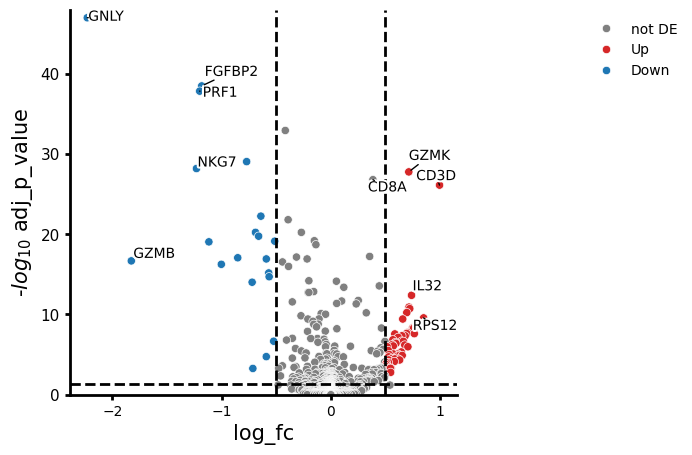

In [12]:
de_res.plot_volcano("CD8_vs_NK", log2fc_thresh=0.5)

Index(['CD8 T cells', 'NK cells'], dtype='object')


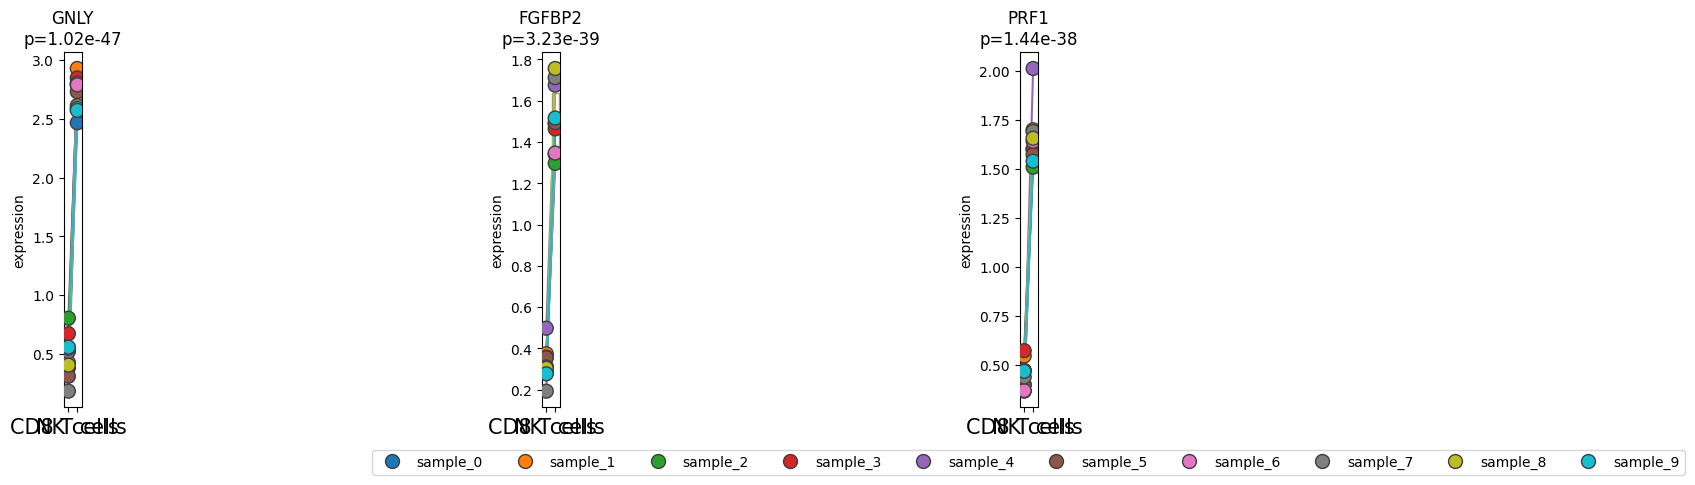

In [13]:
de_res.plot_paired("louvain", "sample", "CD8_vs_NK", groups=["CD8 T cells", "NK cells"], n_top_vars=3)

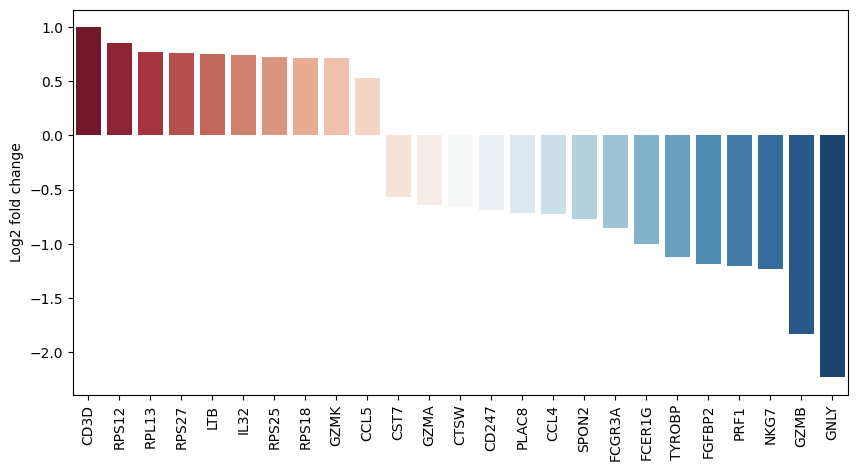

In [14]:
de_res.plot_fold_change("CD8_vs_NK")

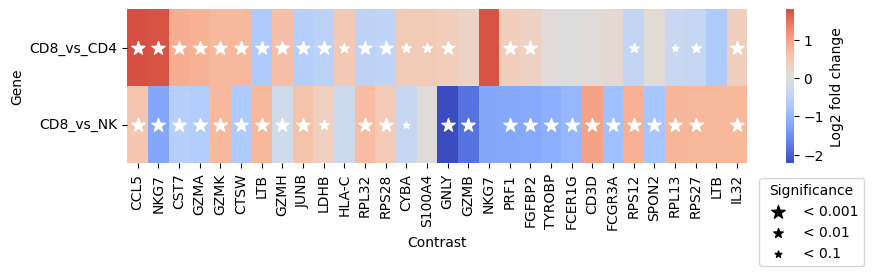

In [15]:
de_res.plot_multicomparison_fc()